In [0]:
"""
Step 1: load ground truth models and ensemble

Step 2: train ensemble on N random data points (including ground truth values)

Step 3: score all of the 10K molecules using the ensemble

Step 4: take ("buy") the top M, and "assess them experimentally" (get their ground truth values)

Step 5: add those samples to the training/seen set

Step 6: retrain the ensemble

Step 7: repeat (make 2-6 repeatable)

Step 8: add some loops over N and M to generate plots of Hx vs N,M
"""

# Retrieve/Import Necessary Packages and Mount File Sysstem

In [0]:
###initialize imports and dataset
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c conda-forge rdkit
#!conda install pytorch torchvision cudatoolkit=9.0 -c pytorch -y
#!pip3 install pyro-ppl

!conda install -y --prefix /usr/local -c conda-forge rdkit joblib simdna
!git clone https://github.com/deepchem/deepchem.git      # Clone deepchem source code from GitHub
!cd deepchem && python setup.py install
!ls -la /usr/local/lib/python3.7/site-packages/deepchem

#!pip install -q tf-nightly-2.0-preview
#%load_ext tensorboard

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import math
import numpy as np
np.random.seed(0)
import pandas as pd
import deepchem as dc
from deepchem.utils.save import load_from_disk
from deepchem.data import data_loader
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
#import datetime

In [0]:
###shouldn't need to do this because the ground truth is in drive now
from google.colab import files
uploaded = files.upload()

In [0]:
from google.colab import drive
drive.mount("drive")

#Prepare Data and Model Definitions

## Load and Featurize Data

In [0]:
dataset_file = "drive/My Drive/ADD19 Datasets/enamineSubset10KGroundTruth.csv"

ground_truth_dataset = pd.read_csv(dataset_file)

low_bace_dataset = ground_truth_dataset.sort_values(by="bace")[:2500] #take 2.5K worst binder potential starters,shouldn't need copy

top_5_percent_index = len(ground_truth_dataset) // 20
top_5_percent_bace_cutoff = ground_truth_dataset.sort_values(by="bace", ascending=False)["bace"].tolist()[top_5_percent_index]

print("Cutoff bace score for 95th percentile:", top_5_percent_bace_cutoff)
print("Columns of dataset: %s" % str(ground_truth_dataset.columns.values))
print("Number of examples in dataset: %s" % str(ground_truth_dataset.shape[0]))

In [4]:
###featurized ground truth for scoring
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)
dataset_feat = loader.featurize(dataset_file) #featurize the molecules from the ground truth dataset
transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
ground_truth_for_scoring = transformer.transform(dataset_feat)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from drive/My Drive/ADD19 Datasets/enamineSubset10KGroundTruth.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 22.016 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 1 took 4.422 s
TIMING: dataset construction took 30.871 s
Loading dataset from disk.
TIMING: dataset construction took 5.804 s
Loading dataset from disk.


##Define Oracle Models

In [0]:
###initialize ground truth models and methods to access them

def load_oracle_models():
    """Loads the pretrained ground truth models for evaluating molecules' properties on-the-fly.
    
    Returns
    -------
    oracle : dict
        A dictionary containing models mapped to their property keywords: "bace", "esol", "logD".
    """
    bace_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/bace")
    esol_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/esol")
    logD_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/logD")
    bace_model.restore()
    esol_model.restore()
    logD_model.restore()
    oracle = {"bace":bace_model, "esol":esol_model, "logD":logD_model} #get each model via the named property
    return oracle

def query_oracle(dataset, oracle):
    """Evaluate molecules on-the-fly for their estimated bace, esol, and logD scores.
    
    Parameters
    ----------
    dataset : pandas.DataFrame
        The input dataset; must includes a field with smiles strings under keyword "SMILES".
    oracle : dictionary( dc.models.GraphConvModel )
        The pretrained ground truth value prediction models.
        
    Returns
    -------
    results : pandas.DataFrame
        Copy of input dataset with newly estimated bace, esol, and logD scores under those headers. 
    """
    query_file = "./temp/oracle_eval.csv"
    dataset.to_csv(query_file)
    
    results = dataset.copy(deep=True) #defensive copy of input dataframe 
    
    featurizer = dc.feat.ConvMolFeaturizer()
    for prop in ("bace", "esol", "logD"):
        #retrieve appropriate model from oracle
        model = oracle[prop]
        
        #load, featurize, and normalize input dataset
        loader = dc.data.CSVLoader(tasks=[prop], smiles_field="SMILES",featurizer=featurizer)
        dataset_feat = loader.featurize(query_file)
        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)
        
        #predict and assign property results to keyword
        predicted = model.predict(dataset_feat)
        results[prop] = predicted
        
    return results

##Define Main Experimenter Model

In [0]:
###define Abstract Data Type to hold search information, including ensemble

class Experimenter():
    """Class representing a research scientist/team going through the drug development process.
    
    Parameters
    ----------
    N : int
        Number of samples to initially train the experimenter ensemble on.
    M : int
        Number of molecules to purchase in each batch.
    ensemble_size : int, optional
        Number of models in experimenter ensemble.
    epochs : int, optional
        Number of epochs to train ensemble models for at each stage.
    molecule_cost : int or float, optional
        Monetary cost of purchasing a single molecule.
    target_bounds : dictionary of str:tuples(floats), optional
        Desired range for each property.
    sampling_mode : string {"thompson", "highest mean", "random"}
        The means of choosing the ensemble outputs/molecules.
    
    Attributes
    ----------
    ensemble : dictionary of deepchem.models.GrachConvModel
        Models representing the experimenter knowledge/predictions and uncertainty.
    history : list of dictionaries storing model attributes
        Snapshots of the model state at each time step.
    samples_seen : pandas.DataFrame
        Ground truth values of the molecules seen before. Includes initial training set.
    smiles_seen : list of str
        SMILES strings of the molecules seen before.
    selected_prediction : pandas.DataFrame
        The molecule values used to make the next decision.
    all_predictions : dict<int,pandas.DataFrame>
        Predicted values of entire ensemble at this time step. Ensemble model keys (random seeds) map to model's prediction.
    cost : int or float
        Total monetary cost incurred at the current time.
    number_molecules : int
        Total number of molecules purchased at the current time.
    time : int
        Total number of days spent up to the current time.
        
    """
    def __init__(self, N, M, ensemble_size=3, epochs=10, molecule_cost=200,
                 target_bounds={"bace":(4, math.inf), "esol":(-5, math.inf), "logD":(-0.4, 5.6)}, sampling_method="highest mean"):
        self.N = N #initial samples
        self.M = M #batch size
        self.ensemble_size = ensemble_size
        self.epochs = epochs
        self.molecule_cost = molecule_cost
        self.target_bounds = target_bounds
        if sampling_method == "thompson" or sampling_method == "highest mean" or sampling_method == "random":
            self.sampling_method = sampling_method
        else:
            raise ValueError("Input for sampling method was not allowed argument. Choices are thompson, highest mean, and random.")
        
        self.ensemble = {i:dc.models.GraphConvModel(n_tasks=3, mode='regression', batch_size=20, random_seed=i, tensorboard=True) 
                         for i in range(self.ensemble_size)} #map each model to its seed
        self.history = [] #save snapshot of model, on disk
        self.samples_seen = None
        self.smiles_seen = []
        self.selected_prediction = pd.DataFrame()
        self.all_predictions = {}
        self.cost = 0
        self.number_molecules = 0
        self.time = 0 #days
        
        
    def train_model(self, model, dataset):
        """Helper function to train a given ensemble model on a given dataset.
        
        Parameters
        ----------
        model : Keras model (generally deepchem.GraphConvModel)
            Model to be trained.
        dataset : pandas.DataFrame
            Dataset to train on. Must include "SMILES", "bace", "esol", and "logD" headers.
            
        """
        #convert DataFrame to CSV and read in as deepchem.Dataset via deepchem.CSVLoader
        
        dataset.to_csv("training_dataset.csv")
        
        featurizer = dc.feat.ConvMolFeaturizer()
        loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)

        dataset_feat = loader.featurize("training_dataset.csv")
        
        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)

        model.fit(dataset_feat, nb_epoch=self.epochs, deterministic=True, restore=False)
    
    
    def train_ensemble(self, dataset):
        """Helper function to train model ensemble.
        
        Parameters
        ----------
        dataset : pandas.Dataset
            Dataset on which to train models. Must include "SMILES", "bace", "esol", and "logD" headers.
        
        """
        for model in self.ensemble.values():
            self.train_model(model, dataset)

    
    def initial_training(self, verbose=False):
        """Train model ensemble for the first time on self.N samples randomly chosen from the 2500 lowest bace affinity-scored 
        molecules.
        
        Parameters
        ----------
        verbose : bool
            Whether to print progress updates.
        
        Notes
        -----
        If self.N > 2500, ensemble will be trained on 2500 samples.
        Records first history object.
        
        """
        idx_range = self.N if self.N < low_bace_dataset.shape[0] else low_bace_dataset.shape[0]
        rand_indices = np.random.choice(range(low_bace_dataset.shape[0]), idx_range, replace=False) #select random row indices
        
        init_ensemble_dataset = pd.DataFrame()
        for idx in rand_indices:
            init_ensemble_dataset = init_ensemble_dataset.append( low_bace_dataset.iloc[idx], ignore_index=True )
        
        if verbose:
            print("Training set selected.")
            
        self.samples_seen = init_ensemble_dataset ### collect the examples seen during initial training (ground truth values)
        self.smiles_seen = init_ensemble_dataset["SMILES"].tolist()
        
        #cost/time to initially train? free initial knowledge?
        self.cost += self.molecule_cost * len(init_ensemble_dataset)
        self.number_molecules += len(init_ensemble_dataset)
        self.time = 0
        

        if self.sampling_method != "random":
            if verbose:
                print("Training ensemble...")
            self.train_ensemble(init_ensemble_dataset) #train ensemble on initial dataset, unless we are randomly sampling and do not need to        
            if verbose:
                print("Ensemble trained.")
                
        self.record_history()

                
    def get_component_score(self, arr, keys):
        """Helper function to get the scaled "goodness" of the input scores.
        
        Parameters
        ----------
        array : numpy.array
             Array with bace, esol, and logD scores.
        keys : collection of strings from {"bace", "esol", "logD"}
            Which scores to incorporate into the overall goodness.
        
        Returns
        -------
        numpy.array
            Sum of component scores.
        
        """
        scores = []
        if "bace" in keys:
            #higher bace => higher score
            bace = arr[:,0]
            bace_range = self.target_bounds["bace"]
            scores.append( np.where(bace < bace_range[0], 0.2*bace-0.8, 0.05*bace-0.2) )
            #dec penalty when score>low end of range
        
        if "esol" in keys:
            esol = arr[:,1]
            esol_range = self.target_bounds["esol"]
            scores.append( np.where(esol < esol_range[0], esol - np.absolute(esol-esol_range[1])**2, esol) )
        
        if "logD" in keys:
            #logD within range is not penalized
            logD = arr[:,2]
            logD_range = self.target_bounds["logD"]
            #handle lower end of range
            int_arr = np.where(logD < logD_range[0], logD - np.absolute(logD-logD_range[0]), logD)
            #handle upper end of range
            scores.append(np.where(int_arr > logD_range[1], int_arr - np.absolute(int_arr-logD_range[1]), int_arr) )

        return sum(scores)
        
    
    def score_and_select_top(self):
        """Scores all molecules and selects the top M for "purchase".
        
        """
        if self.sampling_method == "highest mean":
            #generate and store all predictions
            predicted = np.zeros( (len(ground_truth_for_scoring),3) )
            for key in self.ensemble.keys():
                pred = self.ensemble[key].predict(ground_truth_for_scoring)
                pred = transformer.untransform(pred) #undo normalization on outputs
                predicted += pred #sum model predictions
                self.all_predictions[key] = self.prediction_array_to_dataframe(pred) #store each prediction as a labeled dataframe
            predicted /= len(self.ensemble) #avg model predictions
            results_df = self.prediction_array_to_dataframe(predicted)
            
            
        elif self.sampling_method == "thompson":
            #generate and store all predictions
            for key in self.ensemble.keys():
                pred = self.ensemble[key].predict(ground_truth_for_scoring)
                pred = transformer.untransform(pred) #undo normalization on outputs
                self.all_predictions = { key : self.prediction_array_to_dataframe( pred ) } #store all labeled dataframes       

            
            #Thompson sampling
            results_df = pd.DataFrame()
            for row_idx in range( len(ground_truth_for_scoring) ):
                pred_key = np.random.randint(low=0, high=len(self.ensemble)) #select one random prediction array to select a row from
                pred_df = self.all_predictions[pred_key]
                pred_row = pred_df.iloc[[row_idx]]
                results_df = pd.concat([results_df, pred_row], sort=False)         
        
        
        elif self.sampling_method == "random":
            ###randomly select up to M points from those not seen
            unseen = ground_truth_dataset.loc[~ground_truth_dataset['SMILES'].isin(self.smiles_seen)] #remove prev seen
            unseen = unseen.iloc[np.random.permutation(len(unseen))] #shuffle remaining samples
            unseen = unseen[:self.M] if (len(unseen) > self.M) else unseen #select up to self.M samples
            
            self.samples_seen = pd.concat([self.samples_seen,unseen], sort=False)
            self.smiles_seen = self.samples_seen["SMILES"].tolist()
            self.cost += self.molecule_cost * len(unseen)
            self.number_molecules += len(unseen)
            self.time += 28 #4 weeks to buy and experiment             
            return 
            
        self.selected_prediction = results_df #also store the dataframe with the data we chose to make decisions with
        
        unseen_predicted_rows = results_df.loc[~results_df['SMILES'].isin(self.smiles_seen)] #also remove predicted values previously seen
        unseen_predicted_rows = unseen_predicted_rows.sort_values(by="goodness", ascending=False) #sort predictions with highest goodness at top
        
        predicted_subset = unseen_predicted_rows[:self.M] if (len(unseen_predicted_rows) > self.M) else unseen_predicted_rows #select up to self.M samples from the predictions
        predicted_subset_smiles = predicted_subset["SMILES"].tolist()
        
        new_batch_ground_truth = ground_truth_dataset.loc[ground_truth_dataset['SMILES'].isin(predicted_subset_smiles)]
        
        self.samples_seen = pd.concat([self.samples_seen,new_batch_ground_truth], sort=False)
        self.smiles_seen = self.samples_seen["SMILES"].tolist()
        self.cost += self.molecule_cost * len(new_batch_ground_truth)
        self.number_molecules += len(new_batch_ground_truth)
        self.time += 28 #4 weeks to buy and experiment
    
    
    def prediction_array_to_dataframe(self, array):
        #copy SMILES and assign calculated scores, store in self.predictions
        df = pd.DataFrame()
        df["SMILES"] = ground_truth_dataset["SMILES"]   
        goodness = self.get_component_score(array, ["bace", "esol", "logD"])
        df["bace"] = array[:,0]
        df["esol"] = array[:,1]
        df["logD"] = array[:,2]
        df["goodness"] = goodness
        return df
        
    
    def record_history(self):
        """Stores model costs and experience for later analysis.
        
        Notes
        -----
        Does not save self.history attribute, in order to avoid redundantly storing the data in it.
        Only saves attributes that change in each time step.
        
        """
        hist = {}
        hist["samples_seen"] = self.samples_seen
        hist["smiles_seen"] = self.smiles_seen
        hist["cost"] = self.cost
        hist["number_molecules"] = self.number_molecules
        hist["time"] = self.time
        hist["selected_prediction"] = self.selected_prediction
        hist["all_predictions"] = self.all_predictions
        self.history.append(hist)
     

    def run(self):
        """Simple wrapper to automate calls to select molecules and update models. 
        
        Returns
        -------
        candidates : pandas.DataFrame
            The candidate compounds that satisfy the given criteria.

        Notes
        -----
        Must be preceded by initial training of model ensemble.
        
        """       
        itr = 0
        while len(self.samples_seen) < len(ground_truth_dataset): #search entire database, with early stopping
            
            #THE BELOW LINES STRICTLY ENFORCE THE PROPERTY RANGES DEFINED ABOVE, 
            #candidates = self.samples_seen.loc[self.samples_seen['bace'] >= top_5_percent_bace_cutoff] #find mols w/ high bace
            
            #esol_lower_bound = self.target_bounds["esol"][0]
            #candidates = candidates.loc[candidates['esol'] >= esol_lower_bound] #filter the insoluble mols
            
            #logD_range = self.target_bounds["logD"]
            #candidates = candidates.loc[( candidates['logD'] >= logD_range[0] ) 
            #                                     & ( candidates['logD'] <= logD_range[1] )] #filter for logD in range
              
            #if len(candidates) > 0:
            #    print("Molecule within bounds and 95th percentile bace affinity found.")
            #   return candidates
                
            self.score_and_select_top()
            self.record_history()
            print("PROGRESS:",len(self.samples_seen),"of",len(ground_truth_dataset))
            if self.sampling_method != "random":
                self.train_ensemble(self.samples_seen)
                
            with open("random_model_"+str(itr)+".pickle", "wb") as f:
                pickle.dump(self.history,f)
            itr += 1 

#Run the Model and Obtain Data

In [0]:
#%%prun
%cd /content/drive/My\ Drive/models
!ls
!pwd
#N = [96, 384, 1536] #initial train set size
N = [384]
#M = [96, 384, 1536] #batch size -> 96 wells, multiples
M = [384]

model_hxs = []

for n in N:
    for m in M:
        for i in range(5):
            print("\n","Iteration:",i,"\n")
            model = Experimenter(n, m, ensemble_size=2, epochs=3, sampling_method='random')
            model.initial_training()
            model.run()
            model_hxs.append(model.history)
            break
        
        print("Thompson model trained, and in dict/list.\n")

#Plot Model Performance

In [0]:
top_mols
print(e.history[1]["number_molecules"])

baces = np.array(e.history[1]["samples_seen"]["bace"])
#plt.hist(baces, 50, facecolor='green')

import seaborn as sns
sns.kdeplot(baces,shade=True)
plt.hist(baces, density=True)
plt.show()

#plt.xlabel('baces')
#plt.ylabel('Number of compounds')
#plt.title(r'Histogram of top mol bace scores')
#plt.grid(True)
#plt.show()

In [0]:
for model in models:
    costs = []
    times = []
    top_gt_bace_scores = []
    goodnesses = []
    
    for hx in model.history:
        costs.append(hx["cost"])
        times.append(hx["time"])
        top_gt_bace_scores.append(hx["samples_seen"]["bace"].max()) #max ground truth score seen
        if hx["selected_prediction"].empty:
            goodnesses.append(0)
        else:
            goodnesses.append( hx["selected_prediction"]["goodness"].max() ) #max predicted goodness so far

plt.plot(times,top_gt_bace_scores,'bs',label="top ground truth bace seen")
plt.plot(times,goodnesses,'rs',label="top pred goodness")

plt.xlabel('Time')
plt.title(r'Time vs top ground truth BACE score seen so far')
plt.grid(True)
plt.legend()
plt.show()

In [0]:
gt_bace = ground_truth_dataset["bace"].tolist()
low_bace = low_bace_dataset["bace"].tolist()

x = [i for i in range(len(gt_bace))]
print(min(gt_bace))
print(gt_bace[-1])

plt.clf()
plt.xlim([0,10000])
plt.ylim([2.5,5.6])

plt.plot(x,gt_bace,'bs',label="ground truth bace")
plt.plot(x[:2500],low_bace,'gs',label="low bace set")

plt.xlabel('index')
plt.title(r'bace of gt dataset')
plt.grid(True)
plt.legend()
plt.show()

In [0]:
#take map of dfs
pred_map = e.history[-1]["all_predictions"] #get predictions from latest history
#print(pred_map)

#average their scores
cat_df = pd.DataFrame()
for pred in pred_map.values():
    cat_df = pd.concat([cat_df, pred], sort=False)
avgs = cat_df.groupby("SMILES",as_index=False).mean()

#have one set of mean data, one set of ground truth
pred_bace = avgs.sort_values(by="SMILES")["bace"].tolist()
act_bace = ground_truth_dataset.sort_values(by="SMILES")["bace"].tolist()

#plot baces
plt.scatter(pred_bace,act_bace)
plt.xlabel("Predicted BACE pIC50")
plt.ylabel("Ground truth BACE pIC50")
plt.plot([-2,6], [-2,6], color='k')
plt.show()

In [0]:
#scatterplot for visualizing progress of property prediction models (BACE)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Load the dataset ==> can use 1 dataframe with seen and unseen as different colors -> bool
def plot_gt_pred_scatter(history, itr):    
    pred_df = history[itr]["selected_prediction"]

    for prop in ("bace", "esol", "logD"):
        act = ground_truth_dataset.sort_values(by="SMILES")[prop].tolist()
        pred = pred_df.sort_values(by="SMILES")[prop].tolist()
        seen_smiles = history[itr]["smiles_seen"]
        seen_list = ground_truth_dataset.sort_values(by='SMILES')['SMILES'].isin(seen_smiles).tolist()

        plot_df = pd.DataFrame({"Ground Truth Value":act,"Model Predicted Value":pred,"Sample seen?":seen_list})

        # Draw a scatter plot assigning pt colors and sizes to diff vars in dataset
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        x = np.linspace(-10,10,1000)
        
        if prop == "bace":
            sns.scatterplot(x="Ground Truth Bace pIC50", y="Model Predicted Bace pIC50", hue="Sample seen?", hue_order=[True,False], palette={True:"blue",False:"lightgrey"},
                            linewidth=0, data=plot_df, ax=ax, alpha=0.5, label=f"True, n = {seen_list.count(True), len(plot_df)}")
            plt.xlim(-4,5.5)
            plt.ylim(-4,5.5)
            
        elif prop == "esol":
            sns.scatterplot(x="Ground Truth Solubility log(mol/L)", y="Model Predicted Solubility log(mol/L)", hue="Sample seen?", hue_order=[True,False], palette={True:"blue",False:"lightgrey"},
                            linewidth=0, data=plot_df, ax=ax, alpha=0.5, label=f"True, n = {seen_list.count(True), len(plot_df)}")
            plt.xlim(-6,4)
            plt.ylim(-6,4)
            
        elif prop == "logD":
            sns.scatterplot(x="Ground Truth log Distribution Coefficient", y="Model Predicted log Distribution Coefficient", hue="Sample seen?", hue_order=[True,False], palette={True:"blue",False:"lightgrey"},
                            linewidth=0, data=plot_df, ax=ax, alpha=0.5, label=f"True, n = {seen_list.count(True), len(plot_df)}")
            plt.xlim(-4,3)
            plt.ylim(-4,3)
        
        plt.plot(x,x)
        #plt.legend("upper left")
        plt.show()
        #filename=f'../images/mean_plot_{prop}_{itr}.png'
        #plt.savefig(filename)

In [0]:
%cd /content/drive/My\ Drive/models
!ls

with open("mean_model_25.pickle",'rb') as infile:
    data = pickle.load(infile)

#print(data[1]["selected_prediction"])
#for itr in (1,13,25):
plot_gt_pred_scatter(data,1)

In [0]:
def plot_gt_pred_jointplot(history, itr):    
    pred_df = history[itr]["selected_prediction"]

    for idx, prop in enumerate( ("bace", "esol", "logD") ):
        act = ground_truth_dataset.sort_values(by="SMILES")[prop].tolist()
        pred = pred_df.sort_values(by="SMILES")[prop].tolist()
        
        seen_smiles = history[itr]["smiles_seen"]
        seen_list = ground_truth_dataset.sort_values(by='SMILES')['SMILES'].isin(seen_smiles).tolist()

        plot_df = pd.DataFrame({"Ground Truth Value":act,"Model Predicted Value":pred,"Sample seen?":seen_list})

        # Draw a scatter plot assigning pt colors and sizes to diff vars in dataset
        #f, ax = plt.subplots(figsize=(6.5, 6.5))
        x = np.linspace(-10,10,1000)
        sns.set(font_scale=1.5)
        sns.set_style("white")

        if prop == "bace":
            g = sns.jointplot(act,pred,kind="scatter", data=pred_df,joint_kws={"alpha":0.0})
            x = [a for a,s in zip(act,seen_list) if s == True]
            y = [a for a,s in zip(pred,seen_list) if s == True]
            g.ax_joint.scatter(x,y,color='blue',alpha=0.1, s=5)
            
            x = [a for a,s in zip(act,seen_list) if s == False]
            y = [a for a,s in zip(pred,seen_list) if s == False]
            g.ax_joint.scatter(x,y,color='gray',alpha=0.1, s=5)
            
            plt.xlim(2,6)
            plt.ylim(2,6)
            g.set_axis_labels("Ground Truth Bace pIC50", "Model Predicted Bace pIC50")
            
        elif prop == "esol":
            g = sns.jointplot(act,pred,kind="hex", data=pred_df)
            
            x = [a for a,s in zip(act,seen_list) if s == True]
            y = [a for a,s in zip(pred,seen_list) if s == True]
            g.ax_joint.scatter(x,y,color='blue',alpha=0.1, s=5)
            
            x = [a for a,s in zip(act,seen_list) if s == False]
            y = [a for a,s in zip(pred,seen_list) if s == False]
            g.ax_joint.scatter(x,y,color='gray',alpha=0.1, s=5)
            
            plt.xlim(-6,-2)
            plt.ylim(-6,-2)
            g.set_axis_labels("Ground Truth Solubility log(mol/L)","Model Predicted Solubility log(mol/L)")
            
        elif prop == "logD":
            g = sns.jointplot(act,pred,kind="hex", data=pred_df)
            
            x = [a for a,s in zip(act,seen_list) if s == True]
            y = [a for a,s in zip(pred,seen_list) if s == True]
            g.ax_joint.scatter(x,y,color='blue',alpha=0.1, s=5)
            
            x = [a for a,s in zip(act,seen_list) if s == False]
            y = [a for a,s in zip(pred,seen_list) if s == False]
            g.ax_joint.scatter(x,y,color='gray',alpha=0.1, s=5)
            
            plt.xlim(-3,3)
            plt.ylim(-3,3)
            g.set_axis_labels("Ground Truth log Distribution Coefficient", "Model Predicted log Distribution Coefficient")
        
        #plt.plot(x,x)
        #plt.legend("upper left")
        x0, x1 = g.ax_joint.get_xlim()
        y0, y1 = g.ax_joint.get_ylim()
        lims = [min(x0, y0), max(x1, y1)]
        g.ax_joint.plot(lims, lims, ":k")
        g.ax_marg_x.set_xlim(lims)
        g.ax_marg_y.set_ylim(lims)
        
        plt.autoscale()
        #plt.show()
        
        filename=f'../images/mean_jointplot_{prop}_{itr}.png'
        plt.savefig(filename)

/content/drive/My Drive/models


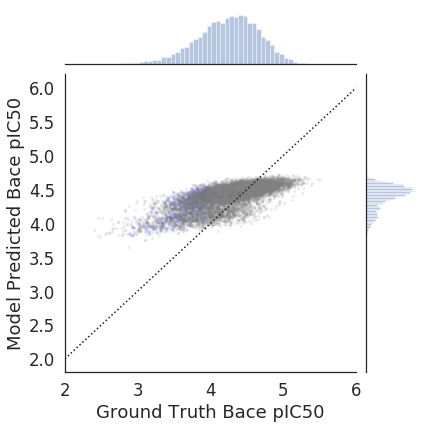

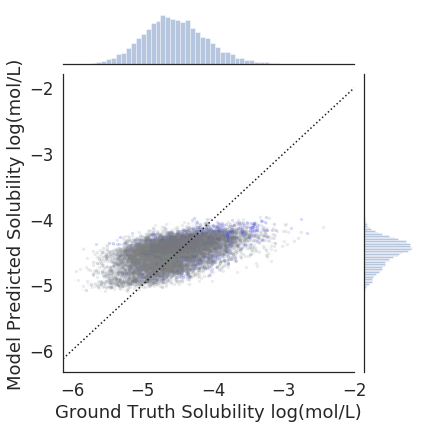

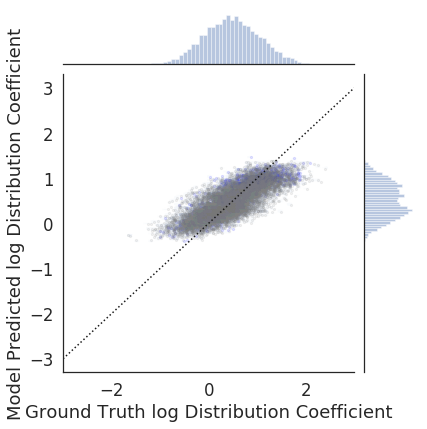

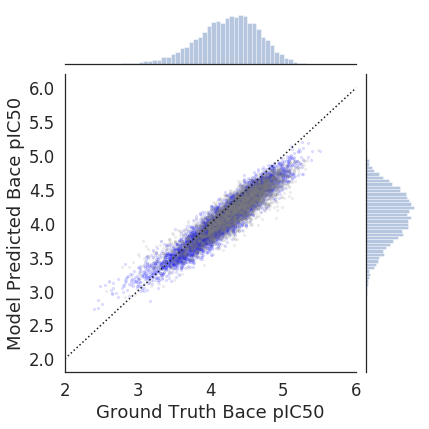

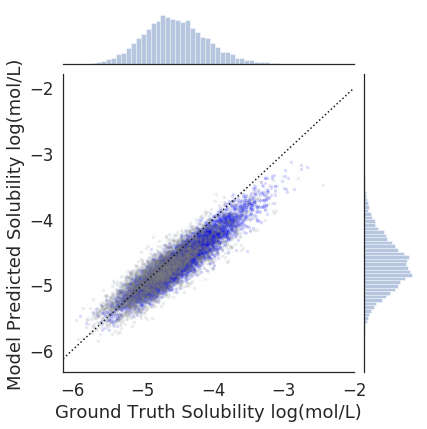

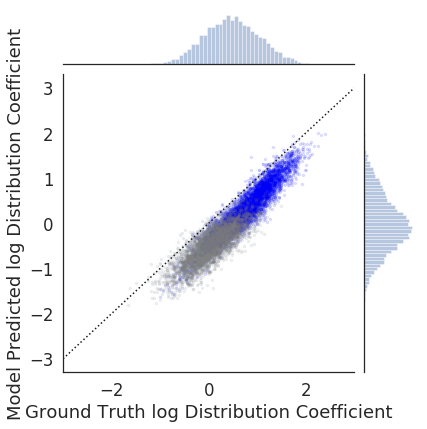

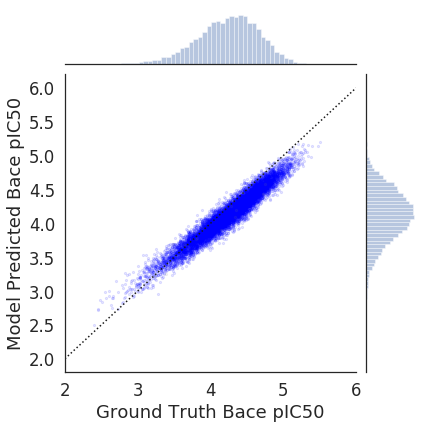

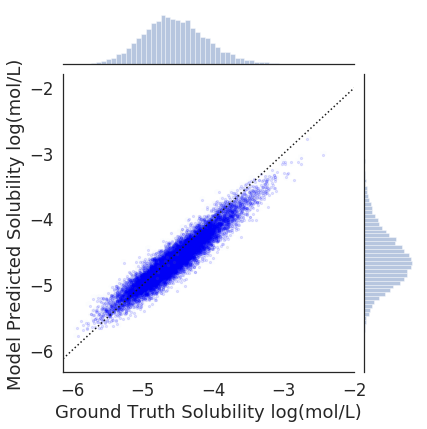

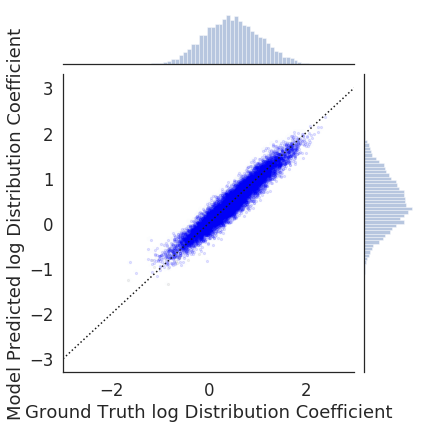

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

%cd /content/drive/My\ Drive/models
#!ls
with open("mean_model_25.pickle",'rb') as infile:
    data = pickle.load(infile)

for itr in (1,13,25):
    plot_gt_pred_jointplot(data,itr)

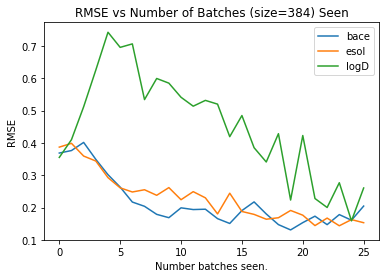

In [18]:
from sklearn.metrics import mean_squared_error

def get_rmse(actual,predicted):
    return np.sqrt( mean_squared_error(actual, predicted) )

def get_all_rmse(history):
    rmse_lists = {"bace":[], "esol":[], "logD":[]}
    
    for idx, prop in enumerate( ("bace", "esol", "logD") ):
        for itr in range(1,len(history)):
            pred_df = history[itr]["selected_prediction"]
            act = ground_truth_dataset.sort_values(by="SMILES")[prop].tolist()
            pred = pred_df.sort_values(by="SMILES")[prop].tolist()
            
            #undo normalization on outputs
            pred = np.array(pred) * transformer.y_stds[idx] + transformer.y_means[idx]  
            
            rmse = get_rmse(act,pred)
            rmse_lists[prop].append(rmse)
    return rmse_lists

rmses = get_all_rmse(data)

plt.plot(rmses["bace"], label="bace")
plt.plot(rmses["esol"], label="esol")
plt.plot(rmses["logD"], label="logD")
plt.xlabel("Number batches seen.")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Batches (size=384) Seen")
plt.legend()
plt.show()

In [0]:
import numpy as np
%cd /content/drive/My\ Drive
random_mean = np.load("./mean_array.npy")

%cd models/
!ls
import pickle
with open("mean_model_25.pickle",'rb') as infile:
    mean_data = pickle.load(infile)
with open("thompson_model_25.pickle",'rb') as infile:
    thompson_data = pickle.load(infile)
with open("random_model_25.pickle",'rb') as infile:
    random_data = pickle.load(infile)

In [0]:
top_mean_bace = []
top_thompson_bace = []
mean_seen = []
thompson_seen = []
random_bace = []
random_seen = []

for i in range(26):
    mean_seen.append( len(mean_data[i]["samples_seen"]) )
    top_mean_bace.append( mean_data[i]["samples_seen"]["bace"].max() )
    top_thompson_bace.append( thompson_data[i]["samples_seen"]["bace"].max() )
    thompson_seen.append(len(thompson_data[i]["samples_seen"]))
    random_bace.append( random_data[i]["samples_seen"]["bace"].max() )
    random_seen.append(len(random_data[i]["samples_seen"]))

In [0]:
plt.xlabel('# Unique Compounds Seen')
plt.ylabel('Highest BACE affinity Seen')
plt.plot(mean_seen, top_mean_bace, "b", label="Highest Mean Model")
plt.plot(thompson_seen, top_thompson_bace, "orange", label="Thompson Sampling Model")
plt.plot(random_seen, random_bace, "mediumseagreen", label="Random Sampling Model")
plt.legend()
plt.savefig("./best_so_far_all")
#plt.show()

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

#print(ground_truth_dataset)
bace = np.array(ground_truth_dataset.bace)

inds = np.arange(len(bace))

bace_trajectories = []
for _ in range(1000):
    np.random.shuffle(inds)
    bace_trajectories.append(np.maximum.accumulate(bace[inds]))

mean_traj = np.mean(bace_trajectories, 0)

eps_list = np.linspace(5,50,2)

ax = plt.subplot(1,1,1)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
for eps in eps_list:
    min_, max_ = np.percentile(bace_trajectories, [eps,100-eps], axis=0)
    plt.fill_between(np.arange(len(inds)), min_, max_, alpha=0.35, color='green')
plt.xlabel('# Unique Compounds Seen')
plt.ylabel('Highest BACE affinity Seen')
plt.plot(mean_seen,top_mean_bace,label="Highest Mean model")
plt.plot(thompson_seen,top_thompson_bace,label="Thompson Sampling Model")
plt.legend()
plt.savefig("./best_so_far_all")

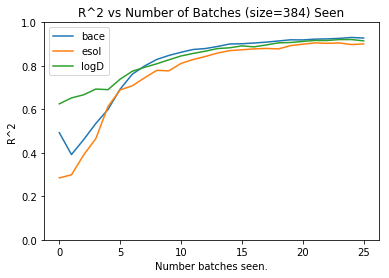

In [15]:
from scipy.stats import linregress

def get_all_r2(history):
    r2_lists = {"bace":[], "esol":[], "logD":[]}
    
    for prop in ("bace", "esol", "logD"):
        for itr in range(1,len(history)):
            pred_df = history[itr]["selected_prediction"]
            act = ground_truth_dataset.sort_values(by="SMILES")[prop].tolist()
            pred = pred_df.sort_values(by="SMILES")[prop].tolist()
            
            _, _, r, _, _ = linregress(act,pred)
            r2 = r**2
            r2_lists[prop].append(r2)
    return r2_lists

r2s = get_all_r2(mean_data)

plt.plot(r2s["bace"], label="bace")
plt.plot(r2s["esol"], label="esol")
plt.plot(r2s["logD"], label="logD")
plt.ylim(0,1)
plt.xlabel("Number batches seen.")
plt.ylabel("R^2")
plt.title("R^2 vs Number of Batches (size=384) Seen")
plt.legend()
#plt.show()
plt.savefig("correct_r2_scores_mean_model", dpi=1200)

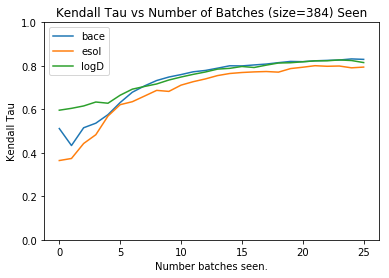

In [21]:
from scipy.stats import kendalltau

def get_all_ktau(history):
    ktau_lists = {"bace":[], "esol":[], "logD":[]}
    
    for prop in ("bace", "esol", "logD"):
        for itr in range(1,len(history)):
            pred_df = history[itr]["selected_prediction"]
            act = ground_truth_dataset.sort_values(by="SMILES")[prop].tolist()
            pred = pred_df.sort_values(by="SMILES")[prop].tolist()
            
            ktau, _ = kendalltau(act,pred)
            ktau_lists[prop].append(ktau)
    return ktau_lists

ktaus = get_all_ktau(mean_data)

plt.plot(ktaus["bace"], label="bace")
plt.plot(ktaus["esol"], label="esol")
plt.plot(ktaus["logD"], label="logD")
plt.ylim(0,1)
plt.xlabel("Number batches seen.")
plt.ylabel("Kendall Tau")
plt.title("Kendall Tau vs Number of Batches (size=384) Seen")
plt.legend()
#plt.show()
plt.savefig("kendall_tau_mean_model")